In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')
import re
import string
from textblob import TextBlob
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import RandomizedSearchCV

from collections import Counter

In [10]:
df=pd.read_csv('sample30.csv')
df.head()

id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   
3  AV16khLE-jtxr-f38VFn              K-Y   
4  AV16khLE-jtxr-f38VFn              K-Y   

                                          categories  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Mo...   
1  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...   
2  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...   
3  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
4  Personal Care,Medicine Cabinet,Lubricant/Sperm...   

                         manufacturer  \
0  Universal Music Group / Cash Money   
1                            Lundberg   
2                            Lundberg   
3                                 K-Y   
4                                 K-Y   

                                         name              reviews_date  \
0   Pink Friday: Roman Reloaded Re-Up (w/dvd)  2012-11-30T06:21:45.000Z   
1  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
2  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
3            K-Y Love Sensuality Pleasure Gel  2016-01-06T00:00:00.000Z   
4            K-Y Love Sensuality Pleasure Gel  2016-12-21T00:00:00.000Z   

  reviews_didPurchase reviews_doRecommend  reviews_rating  \
0                 NaN                 NaN               5   
1                True                 NaN               5   
2                True                 NaN               5   
3               False               False               1   
4               False               False               1   

                                        reviews_text reviews_title  \
0  i love this album. it's very good. more to the...  Just Awesome   
1  Good flavor. This review was collected as part...          Good   
2                                       Good flavor.          Good   
3  I read through the reviews on here before look...  Disappointed   
4  My husband bought this gel for us. The gel cau...    Irritation   

  reviews_userCity reviews_userProvince reviews_username user_sentiment  
0      Los Angeles                  NaN           joshua       Positive  
1              NaN                  NaN        dorothy w       Positive  
2              NaN                  NaN        dorothy w       Positive  
3              NaN                  NaN          rebecca       Negative  
4              NaN                  NaN        walker557       Negative

## Data Preprocessing

In [11]:
df.shape

(30000, 15)

In [12]:
df.dtypes

id                      object
brand                   object
categories              object
manufacturer            object
name                    object
reviews_date            object
reviews_didPurchase     object
reviews_doRecommend     object
reviews_rating           int64
reviews_text            object
reviews_title           object
reviews_userCity        object
reviews_userProvince    object
reviews_username        object
user_sentiment          object
dtype: object

In [13]:
df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [14]:
# Replacing Null values with No Title"
df["reviews_title"].fillna("No Title", inplace = True)

## Concatanate Review Text and Review Title Columns

In [15]:
df["Reviews_Text_and_Title"] = df["reviews_text"] +" "+df["reviews_title"]

In [16]:
df.isnull().sum()

id                            0
brand                         0
categories                    0
manufacturer                141
name                          0
reviews_date                 46
reviews_didPurchase       14068
reviews_doRecommend        2570
reviews_rating                0
reviews_text                  0
reviews_title                 0
reviews_userCity          28071
reviews_userProvince      29830
reviews_username             63
user_sentiment                1
Reviews_Text_and_Title        0
dtype: int64

In [17]:
# We require only two columns Reviews_Text_and_Title and user_sentiment

In [18]:
df = df[["name","Reviews_Text_and_Title","user_sentiment"]]

In [19]:
df.dtypes

name                      object
Reviews_Text_and_Title    object
user_sentiment            object
dtype: object

In [20]:
df.isnull().sum()

name                      0
Reviews_Text_and_Title    0
user_sentiment            1
dtype: int64

In [21]:
df = df.dropna()

In [22]:
df.user_sentiment = df.user_sentiment.map( {'Positive':1 , 'Negative':0} )

In [23]:
df.isnull().sum()

name                      0
Reviews_Text_and_Title    0
user_sentiment            0
dtype: int64

In [24]:
df.shape

(29999, 3)

In [25]:
df.head()

name  \
0   Pink Friday: Roman Reloaded Re-Up (w/dvd)   
1  Lundberg Organic Cinnamon Toast Rice Cakes   
2  Lundberg Organic Cinnamon Toast Rice Cakes   
3            K-Y Love Sensuality Pleasure Gel   
4            K-Y Love Sensuality Pleasure Gel   

                              Reviews_Text_and_Title  user_sentiment  
0  i love this album. it's very good. more to the...               1  
1  Good flavor. This review was collected as part...               1  
2                                  Good flavor. Good               1  
3  I read through the reviews on here before look...               0  
4  My husband bought this gel for us. The gel cau...               0

In [26]:
df=df.groupby('name').filter(lambda x:len(x)>100).reset_index(drop=True)
print('Number of products=>',len(df['name'].unique()))

Number of products=> 35


In [27]:
pd.options.display.max_colwidth=1000
df.head()

name  \
0  Olay Regenerist Deep Hydration Regenerating Cream   
1  Olay Regenerist Deep Hydration Regenerating Cream   
2  Olay Regenerist Deep Hydration Regenerating Cream   
3  Olay Regenerist Deep Hydration Regenerating Cream   
4  Olay Regenerist Deep Hydration Regenerating Cream   

                                                                                                                                                                                                                                                                                                                                                                                           Reviews_Text_and_Title  \
0                                                                                                                  I used (and loved) this product for several years until they changed it. It used to moisturize my skin and left it feeling soft. Now, it sits on top of my skin and is never absorbed. It just leaves a slimy film on my skin. I will no longer purchase this product. New formula is terrible   
1                                                                                                                           I have been using Oil of Olay for over 20 years. This product worked so well for me, but the new formula is HORRIBLE! I cannot find anything to work for my skin like it did! The smell is flowery and it is too thick. The old formula was so light PLEASE BRING BACK OLD FORMULA!!!   
2                                                    I am so disappointed! I have used this product for years because of it's soft smell and great results. The new formula feels greasy, smells awful and I don't feel like my skin looks as toned and wrinkle free anymore. This was a five star product for so many years...why change it Please bring back the old formula. Please bring back the old formula   
3                                                       I've been using this product for years and it was terrific. This improved formula is terrible. It doesn't have the hydrating power it had -- it's much thinner and stickier. Heaven help you if you get some on your lips - it tastes terrible! PLEASE dump this improved formula. Until then, I'm shopping for a new moisturizer... alas What happened!!   
4  It took me so long to find a moisturizer that worked well for me and I loved this product. However, this new formula has a smell that is too strong for me and feels very greasy once applied. Unfortunately I will no longer be purchasing this product and will have to search again for another moisturizer. Please Olay, bring back your old formula. It was so much better. Please Bring Back Old Formula   

   user_sentiment  
0               1  
1               0  
2               1  
3               0  
4               1

In [28]:

df['name'].unique()

array(['Olay Regenerist Deep Hydration Regenerating Cream',
       'Windex Original Glass Cleaner Refill 67.6oz (2 Liter)',
       'Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)',
       'Mike Dave Need Wedding Dates (dvd + Digital)',
       'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)',
       'Pantene Pro-V Expert Collection Age Defy Conditioner',
       'Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack',
       'Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com',
       'The Resident Evil Collection 5 Discs (blu-Ray)',
       '100:Complete First Season (blu-Ray)',
       'Red (special Edition) (dvdvideo)', 'Hormel Chili, No Beans',
       'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
       'Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter',
       "Chester's Cheese Flavored Puffcorn Snacks",
       'Lysol Concentrate Deodorizing Cleaner, 

In [29]:
df.user_sentiment.value_counts(normalize=True)

1    0.891124
0    0.108876
Name: user_sentiment, dtype: float64

In [30]:
#Expand Contractions Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['Reviews_Text_and_Title']=df['Reviews_Text_and_Title'].apply(lambda x:expand_contractions(x))


In [31]:
#Lowercase the reviews

df['cleaned']=df['Reviews_Text_and_Title'].apply(lambda x: x.lower())

In [32]:
#Remove digits and words containing digits
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [33]:
#Remove Punctuations
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [34]:
# Removing extra spaces
df['cleaned']=df['cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [35]:
# Spell Check
#from textblob import TextBlob
#df['cleaned']=df['cleaned'].apply(lambda txt: ''.join(textblob.TextBlob(txt).correct()))

In [36]:
df.head()

name  \
0  Olay Regenerist Deep Hydration Regenerating Cream   
1  Olay Regenerist Deep Hydration Regenerating Cream   
2  Olay Regenerist Deep Hydration Regenerating Cream   
3  Olay Regenerist Deep Hydration Regenerating Cream   
4  Olay Regenerist Deep Hydration Regenerating Cream   

                                                                                                                                                                                                                                                                                                                                                                                           Reviews_Text_and_Title  \
0                                                                                                                  I used (and loved) this product for several years until they changed it. It used to moisturize my skin and left it feeling soft. Now, it sits on top of my skin and is never absorbed. It just leaves a slimy film on my skin. I will no longer purchase this product. New formula is terrible   
1                                                                                                                           I have been using Oil of Olay for over 20 years. This product worked so well for me, but the new formula is HORRIBLE! I cannot find anything to work for my skin like it did! The smell is flowery and it is too thick. The old formula was so light PLEASE BRING BACK OLD FORMULA!!!   
2                                                  I am so disappointed! I have used this product for years because of it is soft smell and great results. The new formula feels greasy, smells awful and I do not feel like my skin looks as toned and wrinkle free anymore. This was a five star product for so many years...why change it Please bring back the old formula. Please bring back the old formula   
3                                                  I have been using this product for years and it was terrific. This improved formula is terrible. It does not have the hydrating power it had -- it is much thinner and stickier. Heaven help you if you get some on your lips - it tastes terrible! PLEASE dump this improved formula. Until then, I am shopping for a new moisturizer... alas What happened!!   
4  It took me so long to find a moisturizer that worked well for me and I loved this product. However, this new formula has a smell that is too strong for me and feels very greasy once applied. Unfortunately I will no longer be purchasing this product and will have to search again for another moisturizer. Please Olay, bring back your old formula. It was so much better. Please Bring Back Old Formula   

   user_sentiment  \
0               1   
1               0   
2               1   
3               0   
4               1   

                                                                                                                                                                                                                                                                                                                                                                                                   cleaned  
0                                                                                                                   i used and loved this product for several years until they changed it it used to moisturize my skin and left it feeling soft now it sits on top of my skin and is never absorbed it just leaves a slimy film on my skin i will no longer purchase this product new formula is terrible  
1                                                                                                                               i have been using oil of olay for over years this product worked so well for me but the new formula is horrible i cannot find anything to work for my skin like it did the smell is flowery and it is too thick the old formula was so 

In [37]:
for index,text in enumerate(df['cleaned'][35:40]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 i did not like the way it felt on my skin i felt like i had on some sort of a skin mask it may be ok for some people but not for me the moisturizer does have a creamy texture to it might be ok for some
Review 2:
 today is my first time using this product felt great going on immediately felt moisturized without being too greasy although it smells great i would have loved to have this formula in a fragrancefree option my skin tends to be a little sensitive to fragrances but i will give a final review in a couple of weeks why no fragrancefree formula
Review 3:
 its keeps your face feeling moisturizer and soft and feels light weight on your skin this review was collected as part of a promotion this product has good features
Review 4:
 it hydrates my skin it is not too thick and heavy when i put it on this review was collected as part of a promotion hydrating but not too heavy
Review 5:
 this product goes on smooth and makes your skin feel great instantly this review was collecte

In [38]:
## Preparing Text Data for Exploratory Data Analysis (EDA)

In [42]:
# Importing spacy
import spacy

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
df['lemmatized']=df['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [43]:
df_grouped=df[['name','lemmatized']].groupby(by='name').agg(lambda x:' '.join(x))
df_grouped.head()

lemmatized
name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
100:Complete First Season (blu-Ray)                                                 unique scifi good premise bad futuristic shortcoming good plot shot america great character adolescent hard believe send try establish live earth old character bad well think series happen apocolapse interesting program decent science fiction television series worth watch good good cw enjoy story plot good season bit rocky typical teen drama past half pick season well go hill fast waste potential pleasant surprise engaging entertaining worth buy gr series interesting keep watch end great way catch series watch season great way catch like season great character story great entertaining watch good cast action enjoyable juvenile delinquent fight survival postapocalyptic world postapocalyptic tv series great quality wonderful customer service good price great great price like way watch summer like movie show well watch start slow end pretty good good tv show see year good bad scifi series especially cw story line kind dumb action love triangle hard straight wish well network like amc h...
Alex Cross (dvdvideo)                                                               read entire alex cross series disappointed movie perry good alex cross alex life long friend samson movie cicely tyson nana momma great actress day slur speech nana retired demand school teacher poor cast sorry buy movie need movie stay close book disappointing cast idris elba originally cast lead role apparently budget cut dramatically stick decision film great deal well tyler perry awful lead scene speak cringe know movie throw away read producer quote switch idris tyler say smith tyler perry like perry league smith come mass market big budget film yes fair success narrow range film type atrocious casting way excited movie bummer meh huge fan james patterson movie good book disappointment feel casting tyler perry alex cross ok movie watch rainy day disappointing movie exciting book good alex cross dvd fan tyler perry madea series probably stomach sit min snore fest save trouble read bookhopefully perry turn stage play alex cross aka madea get gun think story ok action good see mo...
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz  lotion watery separate arrive product excellentit thick concentrated consistency allow little long way time consistency completely know temperature storage delivery process bad batch try sure purchase instore online mess product receive expire month star time infant rub eye cry favor buy infant toddler tear free tear free useful extremely disappointed product sure test small patch child skin aveeno product problem buy child liberally apply follow direction child face product give severe allergic reaction cheek nose puff skin inflame red eye nearly swollen shut think allergy sunscreen protection ingredient sad awful baby parent beware come expiry

In [44]:
#Document Term Matrix

# Creating Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(df_grouped['lemmatized'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=df_grouped.index
df_dtm.head()

aaa  \
name                                                                                      
100:Complete First Season (blu-Ray)                                                   0   
Alex Cross (dvdvideo)                                                                 0   
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz    0   
Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter       0   
Burt's Bees Lip Shimmer, Raisin                                                       0   

                                                                                    aaaaaaaaaaaaaaaaa  \
name                                                                                                    
100:Complete First Season (blu-Ray)                                                                 0   
Alex Cross (dvdvideo)                                                                               0   
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz                  0   
Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter                     0   
Burt's Bees Lip Shimmer, Raisin                                                                     0   

                                                                                    aaahhhhh  \
name                                                                                           
100:Complete First Season (blu-Ray)                                                        0   
Alex Cross (dvdvideo)                                                                      0   
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz         0   
Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter            0   
Burt's Bees Lip Shimmer, Raisin                                                            0   

                                                                                    aaammmaaaze  \
name                                                                                              
100:Complete First Season (blu-Ray)                                                           0   
Alex Cross (dvdvideo)                                                                         0   
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz            0   
Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter               0   
Burt's Bees Lip Shimmer, Raisin                                                               0   

                                                                                    aalot  \
name                                                                                        
100:Complete First Season (blu-Ray)                                                     0   
Alex Cross (dvdvideo)                                                                   0   
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz      0   
Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter         0   
Burt's Bees Lip Shimmer, Raisin                                                         0   

                                                                                    aanyhwere  \
name                                                                                            
100:Complete First Season (blu-Ray)                                                         0   
Alex Cross (dvdvideo)                                                                       0   
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz          0   
Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter             0   
Burt's Bees Lip Shimmer, Raisin                                                             0   

           

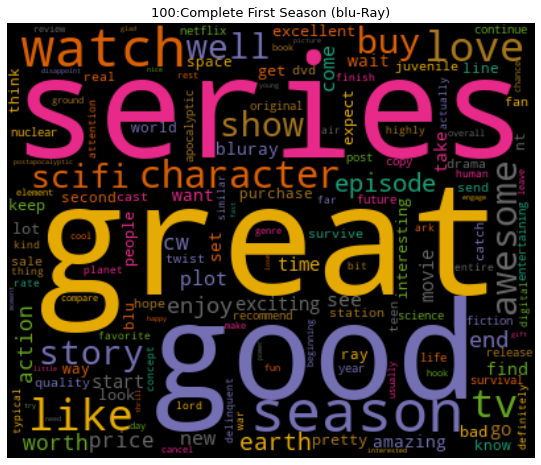

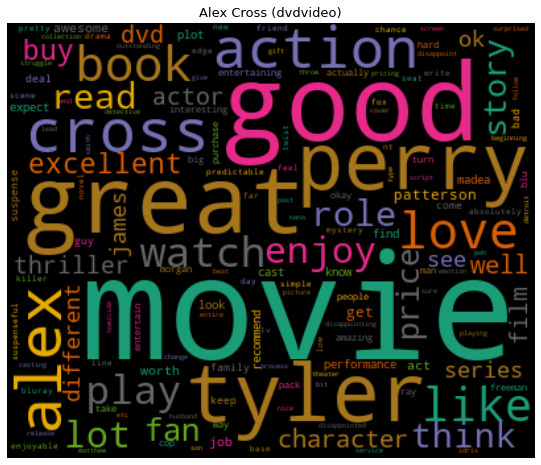

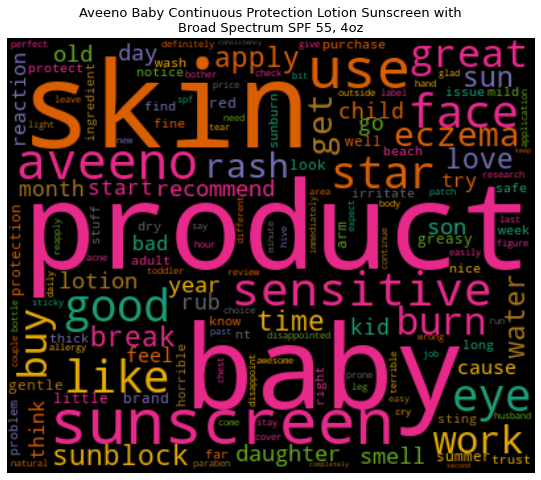

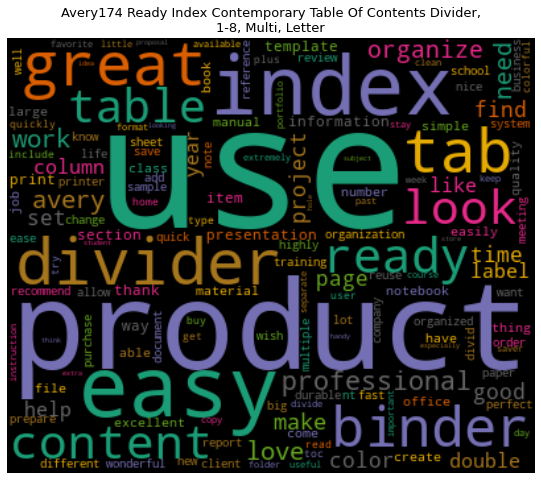

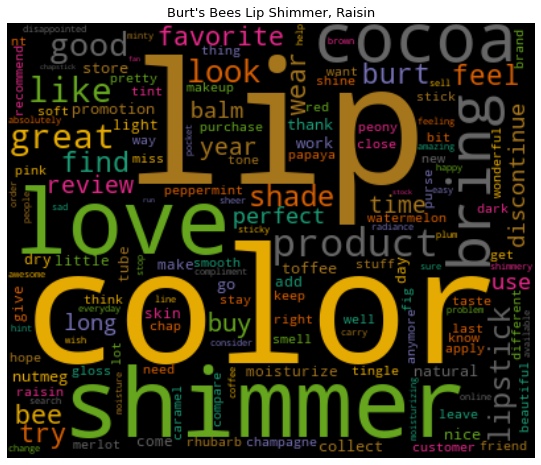

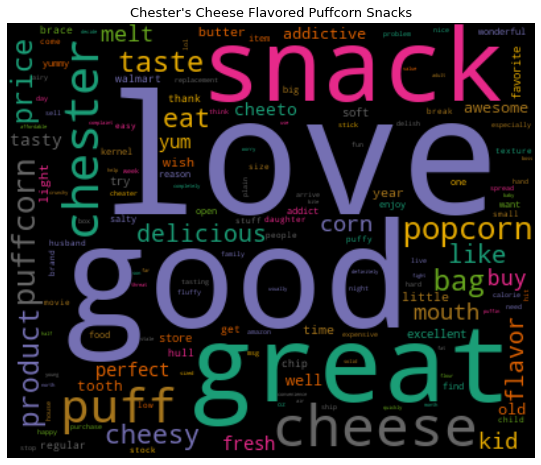

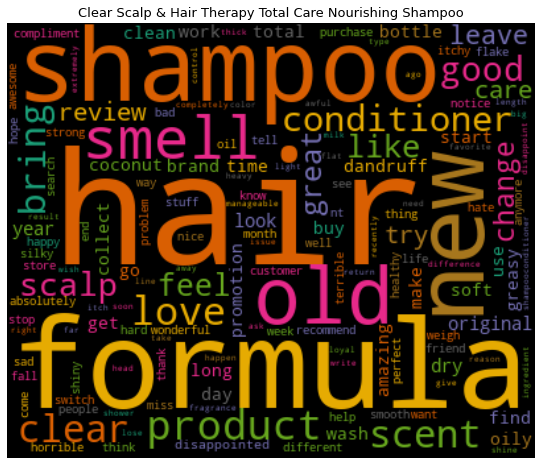

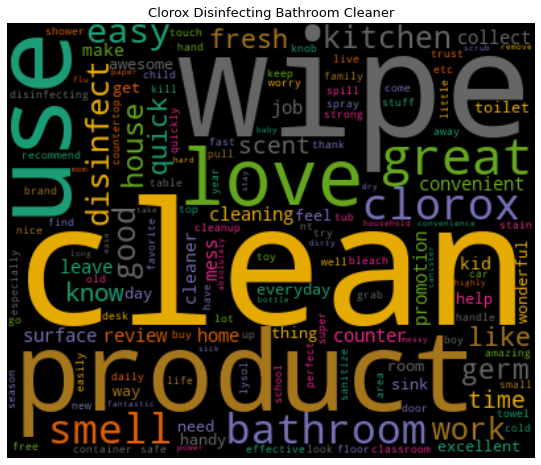

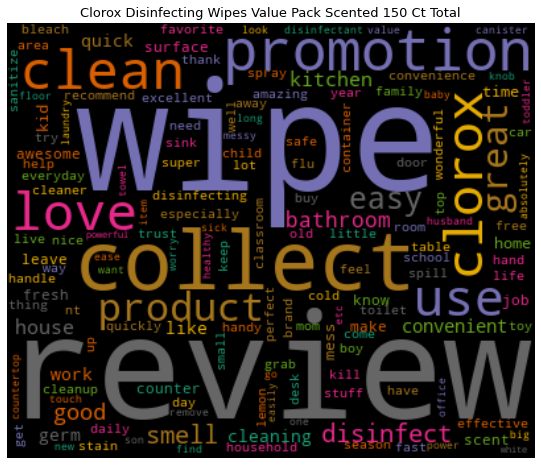

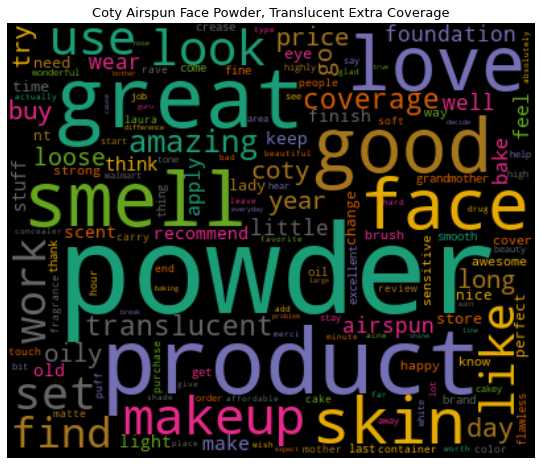

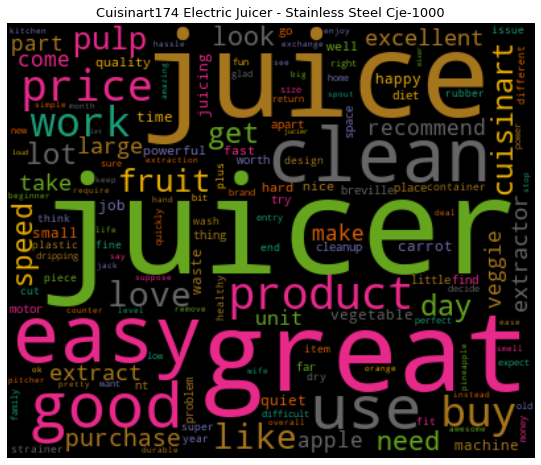

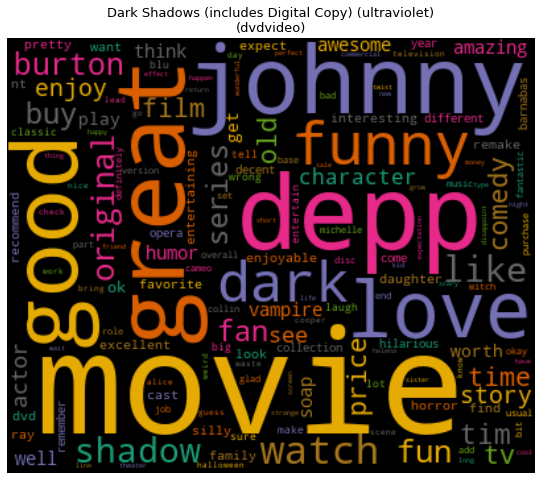

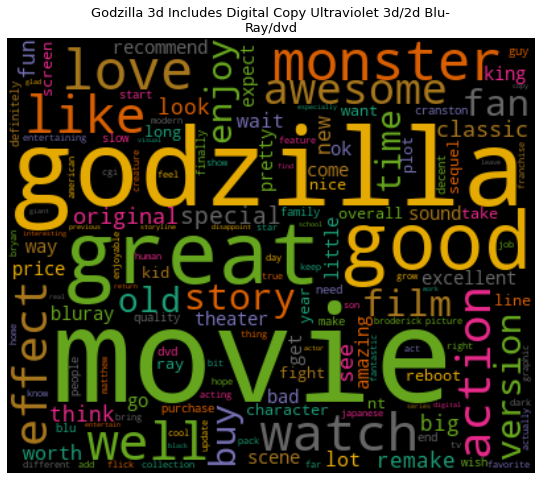

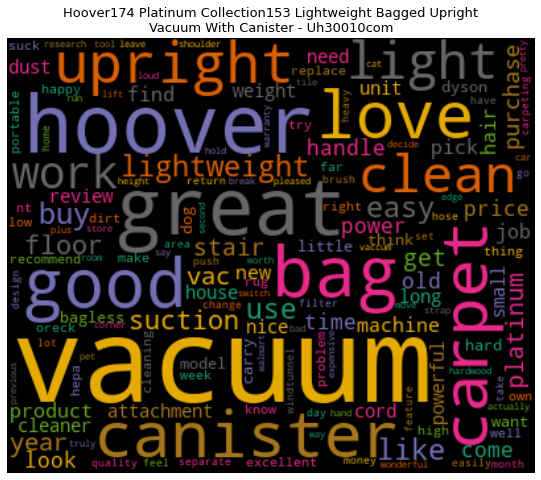

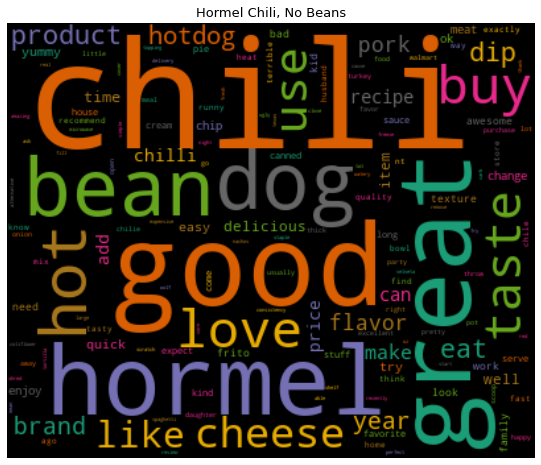

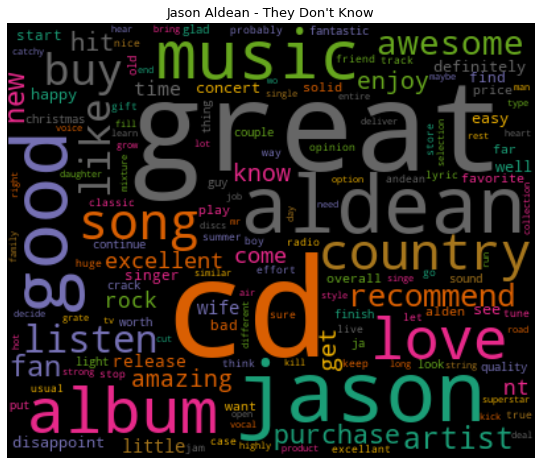

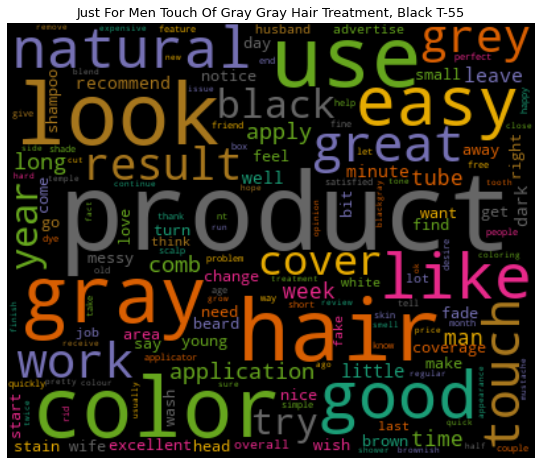

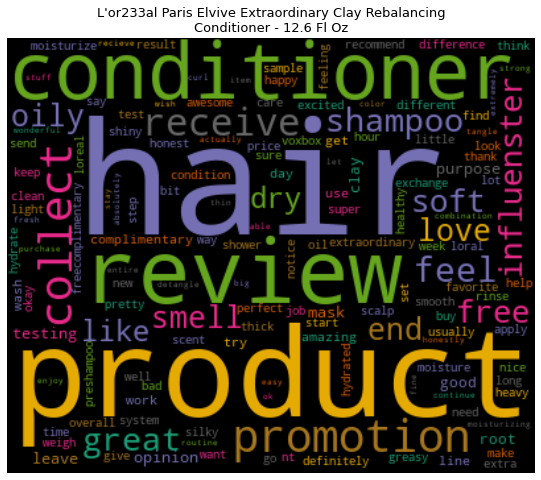

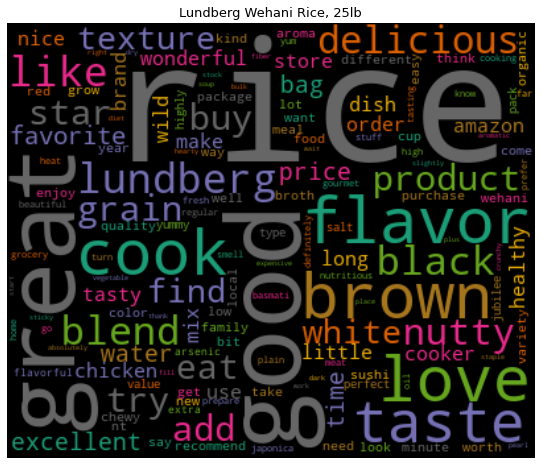

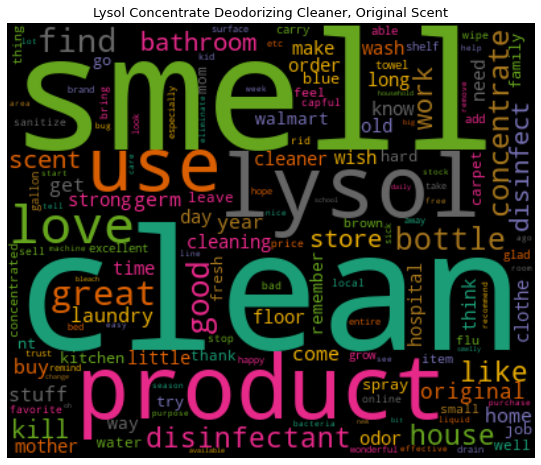

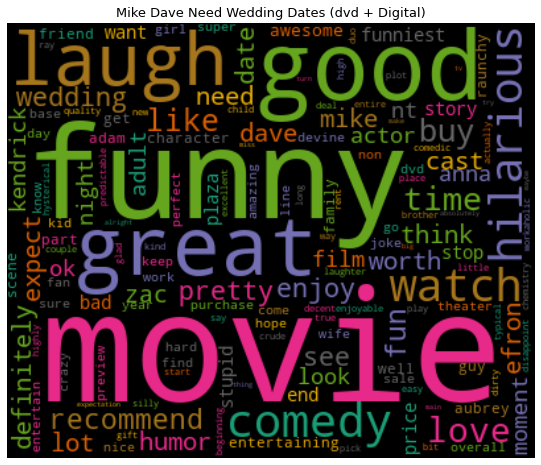

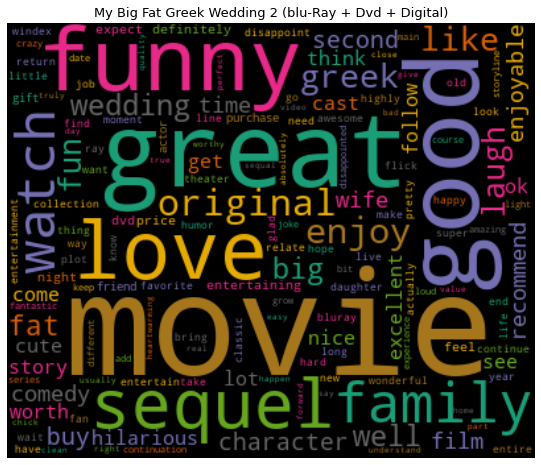

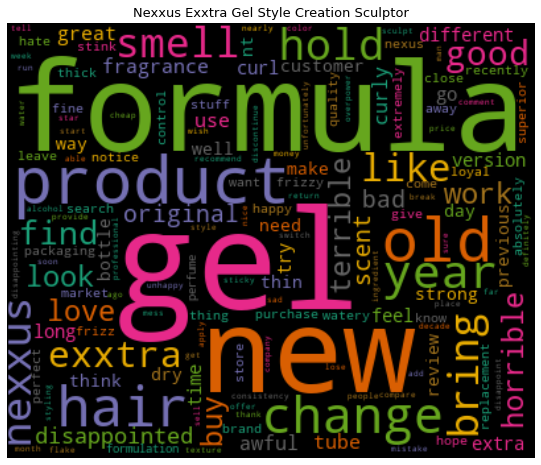

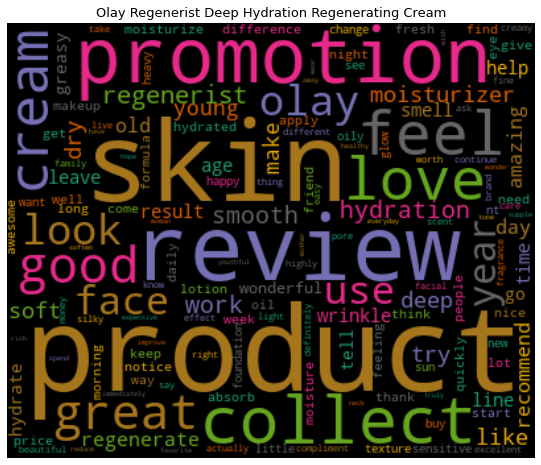

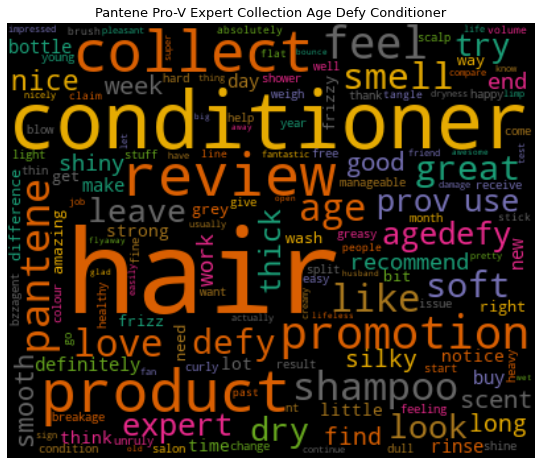

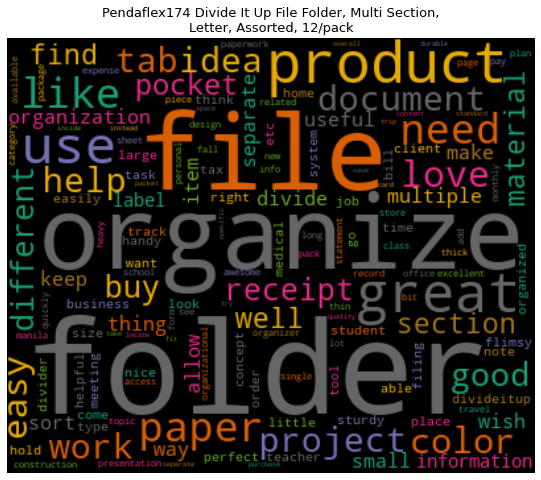

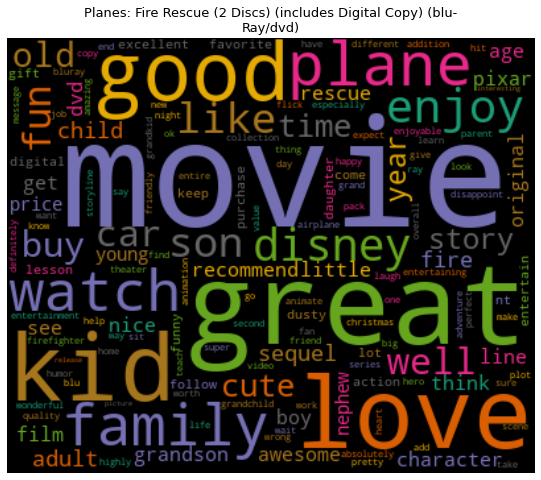

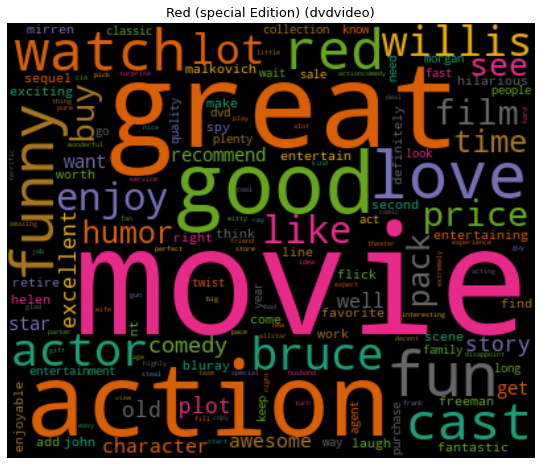

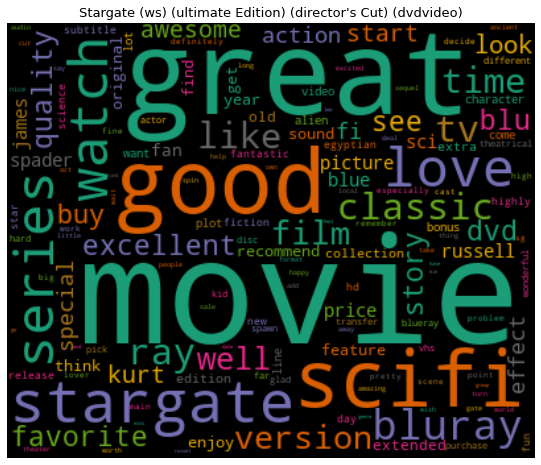

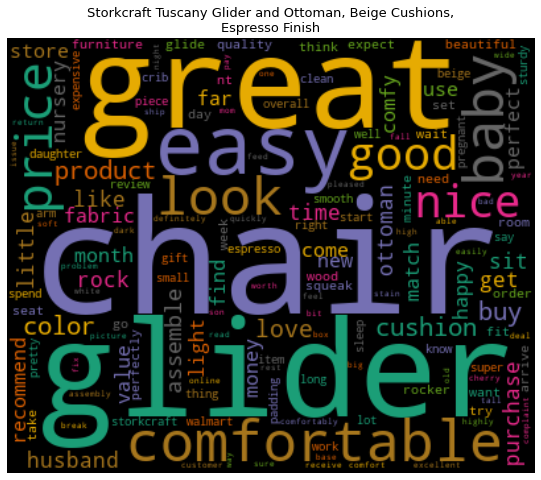

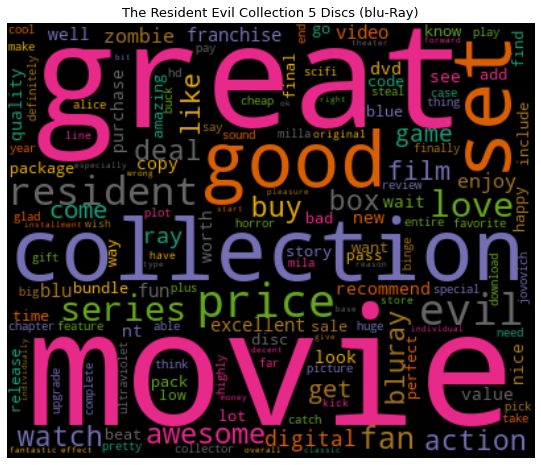

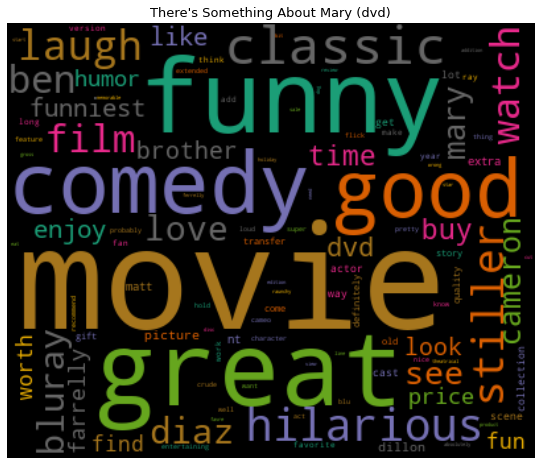

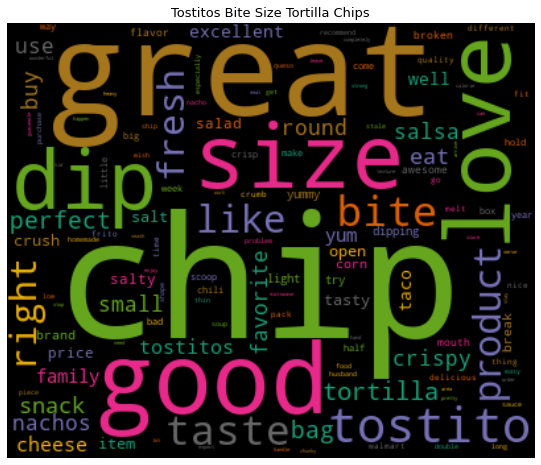

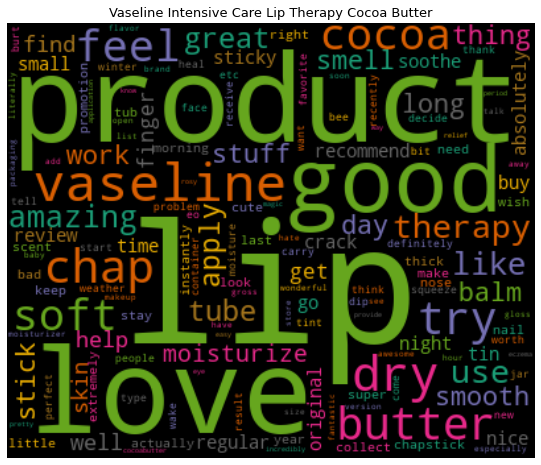

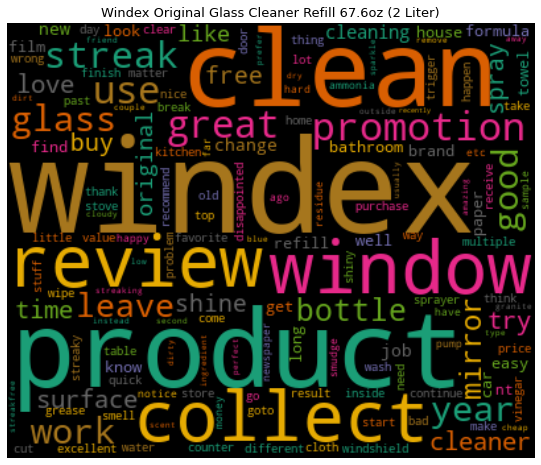

In [46]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
# Transposing document term matrix
df_dtm=df_dtm.transpose()

# Plotting word cloud for each product
for index,product in enumerate(df_dtm.columns):
  generate_wordcloud(df_dtm[product].sort_values(ascending=False),product)


In [47]:
# Polarity
from textblob import TextBlob
df['polarity']=df['lemmatized'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [48]:
print("3 Random Reviews with Highest Polarity:")
for index,review in enumerate(df.iloc[df['polarity'].sort_values(ascending=False)[:3].index]['Reviews_Text_and_Title']):
  print('Review {}:\n'.format(index+1),review)

3 Random Reviews with Highest Polarity:
Review 1:
 I use these all the time and woulnd't use anything else. awesome product
Review 2:
 I used this product to organize my income tax information. It was perfect for the types of paperwork I needed to separate and archive. Perfect For Organizing Events And To-dos
Review 3:
 Wonderful Wonderful


In [49]:
print("3 Random Reviews with Lowest Polarity:")
for index,review in enumerate(df.iloc[df['polarity'].sort_values(ascending=True)[:3].index]['Reviews_Text_and_Title']):
  print('Review {}:\n'.format(index+1),review)

3 Random Reviews with Lowest Polarity:
Review 1:
 This was a boring movie i couldnt watch 20 minutes Mike
Review 2:
 I have used this product for over 20 years and cannot believe they changed it! like all other reviews smells horrible , consistency is watery and leaves hair crunchy. I have been on the hunt for something that works the, same and have not found anything! So if any of you have please share! Why change it
Review 3:
 We use these in my classroom to help keep those nasty germs away. This review was collected as part of a promotion. School Teacher


In [50]:
#plot polarities of reviews for each product and compare them

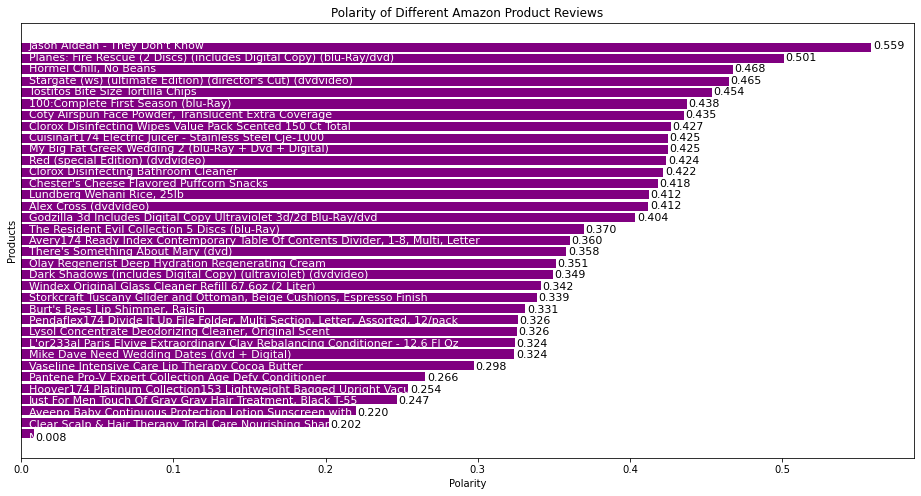

In [51]:
product_polarity_sorted=pd.DataFrame(df.groupby('name')['polarity'].mean().sort_values(ascending=True))

plt.figure(figsize=(16,8))
plt.xlabel('Polarity')
plt.ylabel('Products')
plt.title('Polarity of Different Amazon Product Reviews')
polarity_graph=plt.barh(np.arange(len(product_polarity_sorted.index)),product_polarity_sorted['polarity'],color='purple',)

# Writing product names on bar
for bar,product in zip(polarity_graph,product_polarity_sorted.index):
  plt.text(0.005,bar.get_y()+bar.get_width(),'{}'.format(product),va='center',fontsize=11,color='white')

# Writing polarity values on graph
for bar,polarity in zip(polarity_graph,product_polarity_sorted['polarity']):
  plt.text(bar.get_width()+0.001,bar.get_y()+bar.get_width(),'%.3f'%polarity,va='center',fontsize=11,color='black')
  
plt.yticks([])
plt.show()


In [52]:
df.head()

name  \
0  Olay Regenerist Deep Hydration Regenerating Cream   
1  Olay Regenerist Deep Hydration Regenerating Cream   
2  Olay Regenerist Deep Hydration Regenerating Cream   
3  Olay Regenerist Deep Hydration Regenerating Cream   
4  Olay Regenerist Deep Hydration Regenerating Cream   

                                                                                                                                                                                                                                                                                                                                                                                           Reviews_Text_and_Title  \
0                                                                                                                  I used (and loved) this product for several years until they changed it. It used to moisturize my skin and left it feeling soft. Now, it sits on top of my skin and is never absorbed. It just leaves a slimy film on my skin. I will no longer purchase this product. New formula is terrible   
1                                                                                                                           I have been using Oil of Olay for over 20 years. This product worked so well for me, but the new formula is HORRIBLE! I cannot find anything to work for my skin like it did! The smell is flowery and it is too thick. The old formula was so light PLEASE BRING BACK OLD FORMULA!!!   
2                                                  I am so disappointed! I have used this product for years because of it is soft smell and great results. The new formula feels greasy, smells awful and I do not feel like my skin looks as toned and wrinkle free anymore. This was a five star product for so many years...why change it Please bring back the old formula. Please bring back the old formula   
3                                                  I have been using this product for years and it was terrific. This improved formula is terrible. It does not have the hydrating power it had -- it is much thinner and stickier. Heaven help you if you get some on your lips - it tastes terrible! PLEASE dump this improved formula. Until then, I am shopping for a new moisturizer... alas What happened!!   
4  It took me so long to find a moisturizer that worked well for me and I loved this product. However, this new formula has a smell that is too strong for me and feels very greasy once applied. Unfortunately I will no longer be purchasing this product and will have to search again for another moisturizer. Please Olay, bring back your old formula. It was so much better. Please Bring Back Old Formula   

   user_sentiment  \
0               1   
1               0   
2               1   
3               0   
4               1   

                                                                                                                                                                                                                                                                                                                                                                                                   cleaned  \
0                                                                                                                   i used and loved this product for several years until they changed it it used to moisturize my skin and left it feeling soft now it sits on top of my skin and is never absorbed it just leaves a slimy film on my skin i will no longer purchase this product new formula is terrible   
1                                                                                                                               i have been using oil of olay for over years this product worked so well for me but the new formula is horrible i cannot find anything to work for my skin like it did the smell is flowery and it is too thick the old formula was s

In [53]:
df_latest = df.drop(columns=['Reviews_Text_and_Title', 'cleaned','polarity'])

In [54]:
df_latest.head()

name  user_sentiment  \
0  Olay Regenerist Deep Hydration Regenerating Cream               1   
1  Olay Regenerist Deep Hydration Regenerating Cream               0   
2  Olay Regenerist Deep Hydration Regenerating Cream               1   
3  Olay Regenerist Deep Hydration Regenerating Cream               0   
4  Olay Regenerist Deep Hydration Regenerating Cream               1   

                                                                                                                                                                                              lemmatized  
0                                                              love product year change moisturize skin leave feel soft sit skin absorb leave slimy film skin long purchase product new formula terrible  
1                                                                            oil olay year product work new formula horrible find work skin like smell flowery thick old formula light bring old formula  
2  disappointed product year soft smell great result new formula feel greasy smell awful feel like skin look toned wrinkle free anymore star product yearswhy change bring old formula bring old formula  
3                                       product year terrific improved formula terrible hydrating power thin sticki heaven help lip taste terrible dump improve formula shop new moisturizer alas happen  
4           take long find moisturizer work love product new formula smell strong feel greasy apply unfortunately long purchase product search moisturizer olay bring old formula well bring old formula

In [55]:
df_latest.columns = ['name', 'user_sentiment', 'Reviews_Text_and_Title']

In [56]:
df_latest.shape

(26691, 3)

In [57]:
df_latest.head()

name  user_sentiment  \
0  Olay Regenerist Deep Hydration Regenerating Cream               1   
1  Olay Regenerist Deep Hydration Regenerating Cream               0   
2  Olay Regenerist Deep Hydration Regenerating Cream               1   
3  Olay Regenerist Deep Hydration Regenerating Cream               0   
4  Olay Regenerist Deep Hydration Regenerating Cream               1   

                                                                                                                                                                                  Reviews_Text_and_Title  
0                                                              love product year change moisturize skin leave feel soft sit skin absorb leave slimy film skin long purchase product new formula terrible  
1                                                                            oil olay year product work new formula horrible find work skin like smell flowery thick old formula light bring old formula  
2  disappointed product year soft smell great result new formula feel greasy smell awful feel like skin look toned wrinkle free anymore star product yearswhy change bring old formula bring old formula  
3                                       product year terrific improved formula terrible hydrating power thin sticki heaven help lip taste terrible dump improve formula shop new moisturizer alas happen  
4           take long find moisturizer work love product new formula smell strong feel greasy apply unfortunately long purchase product search moisturizer olay bring old formula well bring old formula

In [58]:
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

all_text=df_latest['Reviews_Text_and_Title']
train_text=df_latest['Reviews_Text_and_Title']
y=df_latest['user_sentiment']

In [59]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)

In [60]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)

train_features = hstack([train_char_features, train_word_features])

In [61]:
train_features_nd =train_features.toarray()

In [62]:
train_features_nd

array([[0.01830005, 0.0397473 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02560527, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, y,test_size=0.3,random_state=101)

### Logistic Regression

In [64]:
logit=LogisticRegression()

In [65]:
logit.fit(X_train,y_train)

LogisticRegression()

In [66]:
y_train_logit = logit.predict_proba(X_train)[:,1]
y_test_logit = logit.predict_proba(X_test)[:,1]

In [67]:
y_train_logit

array([0.94921876, 0.98809068, 0.9966391 , ..., 0.94964342, 0.95696782,
       0.98892632])

In [68]:
y_test_logit

array([0.98420404, 0.99359973, 0.99196753, ..., 0.95453988, 0.94836565,
       0.9728327 ])

In [69]:
print('Precision Logistic Regression test:', precision_score(y_test, logit.predict(X_test)))

Precision Logistic Regression test: 0.9181499285435885


In [70]:
print('Recall Logistic Regression test:', recall_score(y_test, logit.predict(X_test), pos_label=1))

Recall Logistic Regression test: 0.9904695164681149


In [71]:
print('F-measure Logistic Regression test:', f1_score(y_test, logit.predict(X_test), pos_label=1))

F-measure Logistic Regression test: 0.9529395900755124


### Random Classifier

In [72]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

y_train_rf = rf.predict_proba(X_train)[:,1]
y_test_rf = rf.predict_proba(X_test)[:,1]

In [73]:
print('Precision Random Forest test:', precision_score(y_test, rf.predict(X_test)))

Precision Random Forest test: 0.913607188703466


In [74]:
print('Recall Random Forest test:', recall_score(y_test, rf.predict(X_test), pos_label=1))

Recall Random Forest test: 0.9974772249474422


In [75]:
print('F-measure Random Forest test:', f1_score(y_test, rf.predict(X_test), pos_label=1))

F-measure Random Forest test: 0.9537018425460636


### XG Boost

In [76]:
xgb=xgb.XGBClassifier()

In [77]:
xgb.fit(X_train,y_train)

[16:07:57] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [78]:
y_train_xgb = xgb.predict_proba(X_train)[:,1]
y_test_xgb = xgb.predict_proba(X_test)[:,1]

In [79]:
print('Precision XG Boost test:', precision_score(y_test, xgb.predict(X_test)))

Precision XG Boost test: 0.9303922863558315


In [80]:
print('Recall XG Boost test:', recall_score(y_test, xgb.predict(X_test), pos_label=1))

Recall XG Boost test: 0.9872459705676244


In [81]:
print('F-measure XG Boost test:', f1_score(y_test, xgb.predict(X_test), pos_label=1))

F-measure XG Boost test: 0.9579763361893104


### Naive Bayes

In [82]:
nb = MultinomialNB()


In [83]:
nb.fit(X_train,y_train)

MultinomialNB()

In [84]:
print('Precision Naive Bayes test:', precision_score(y_test, nb.predict(X_test)))

Precision Naive Bayes test: 0.9073689673066944


In [85]:
print('Recall Naive Bayes test:', recall_score(y_test, nb.predict(X_test), pos_label=1))

Recall Naive Bayes test: 0.9802382620882971


In [86]:
print('F-measure Naive Bayes test:', f1_score(y_test, nb.predict(X_test), pos_label=1))

F-measure Naive Bayes test: 0.9423970895371556


## Class Imbalance

### SMOTE

In [89]:
counter = Counter(y_train)
print("Before: ",counter)

smt= SMOTE()
X_train_sm,y_train_sm=smt.fit_resample(X_train,y_train)

counter = Counter(y_train_sm)
print("After: ",counter)

Before:  Counter({1: 16650, 0: 2033})
After:  Counter({1: 16650, 0: 16650})


In [91]:
y_train_sm.value_counts()

1    16650
0    16650
Name: user_sentiment, dtype: int64

## Logistic Regression After SMOTE Class Imbalance

In [93]:
logit=LogisticRegression()

logit.fit(X_train_sm,y_train_sm)


print('Precision Logistic Regression test:', precision_score(y_test, logit.predict(X_test)))

print('Recall Logistic Regression test:', recall_score(y_test, logit.predict(X_test), pos_label=1))

print('F-measure Logistic Regression test:', f1_score(y_test, logit.predict(X_test), pos_label=1))

Precision Logistic Regression test: 0.96500812047837
Recall Logistic Regression test: 0.9160476524176594
F-measure Logistic Regression test: 0.9398907103825137


## Random Forest Calssifier After SMOTE Class Imbalance

In [94]:
rf = RandomForestClassifier()

rf.fit(X_train_sm, y_train_sm)


print('Precision Random Forest test:', precision_score(y_test, rf.predict(X_test)))

print('Recall Random Forest test:', recall_score(y_test, rf.predict(X_test), pos_label=1))

print('F-measure Random Forest test:', f1_score(y_test, rf.predict(X_test), pos_label=1))

Precision Random Forest test: 0.9335748792270532
Recall Random Forest test: 0.9750525578135949
F-measure Random Forest test: 0.9538630287242065


## XG Boost After SMOTE Class Imbalance

In [97]:
import xgboost as xgb
xgb=xgb.XGBClassifier()

xgb.fit(X_train_sm,y_train_sm)


print('Precision XG Boost test:', precision_score(y_test, xgb.predict(X_test)))

print('Recall XG Boost test:', recall_score(y_test, xgb.predict(X_test), pos_label=1))

print('F-measure XG Boost test:', f1_score(y_test, xgb.predict(X_test), pos_label=1))

[16:22:27] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precision XG Boost test: 0.9341891891891891
Recall XG Boost test: 0.9688857743517869
F-measure XG Boost test: 0.9512211902304781


## Naive Bayes After SMOTE Class Imbalance

In [98]:
nb = MultinomialNB()


nb.fit(X_train_sm,y_train_sm)

print('Precision Naive Bayes test:', precision_score(y_test, nb.predict(X_test)))

print('Recall Naive Bayes test:', recall_score(y_test, nb.predict(X_test), pos_label=1))

print('F-measure Naive Bayes test:', f1_score(y_test, nb.predict(X_test), pos_label=1))

Precision Naive Bayes test: 0.9458963778083448
Recall Naive Bayes test: 0.8674141555711282
F-measure Naive Bayes test: 0.9049568650387484
